# Doggos vs Cattos

### Computer Vision

### Project: Build a Support Vector Machine classifier that will classify pictures of dogs and cats.
_**Doggos vs Cattos**_ is a machine learning project focused on researching how diffrent learning algorithms perform in terms of classification RGB images and what kind of information can be mined using them.

### Load and normalize images

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dogs_vs_cats import data_utils

plt.rcParams['figure.figsize'] = (7.0, 7.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some magic so that the notebook will reload external python modules
%load_ext autoreload
%autoreload 2

In [2]:
# Cleaning up variable to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

img_width = 96
img_height = 96
channels = 3

(X_train, y_train), (X_test, y_test) = data_utils.load_data(image_dim=(img_width, img_height))

print('Training data shape: ', X_train.shape)
print('Training label shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test label shape: ', y_test.shape)

Found 18000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Training data shape:  (18000, 96, 96, 3)
Training label shape:  (18000,)
Test data shape:  (5000, 96, 96, 3)
Test label shape:  (5000,)


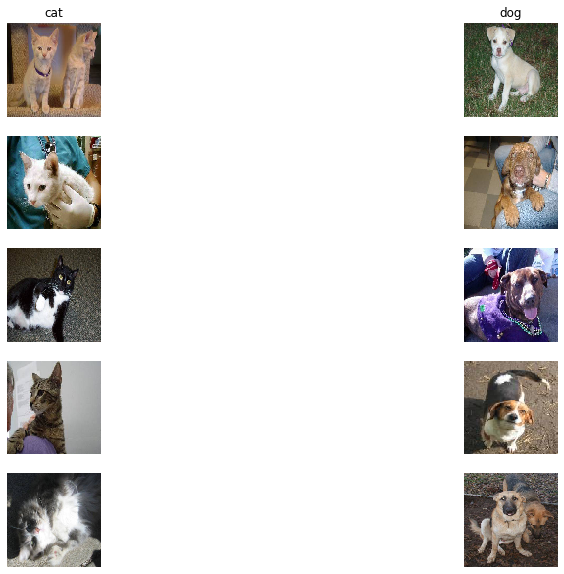

In [3]:
# Visualize some examples from a dataset
classes = ['cat', 'dog']
num_classes = len(classes)
samples_per_class = 5

figure = plt.figure(figsize=(15.0, 10.0))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

In [4]:
# Reshape the image into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(18000, 27648) (5000, 27648)


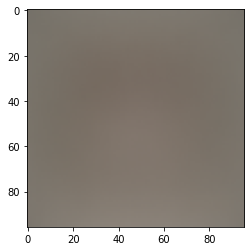

In [5]:
mean_img = np.mean(X_train, axis=0)

# Normalize images
X_train -= mean_img
X_test -= mean_img

# Plot mean image
mean_img = np.reshape(mean_img, (img_width, img_height, channels)).astype('uint8')
plt.imshow(mean_img)

### Support Vector Machine with _linear_ kernel to show model's classification filter

In [6]:
def plot_filter(coefs):
    # Rescale coefficients to be between [0, 1]
    coefs -= np.min(coefs)
    coefs /= np.max(coefs)
    filter = coefs.reshape((img_width, img_height, channels))
    
    plt.imshow(filter)

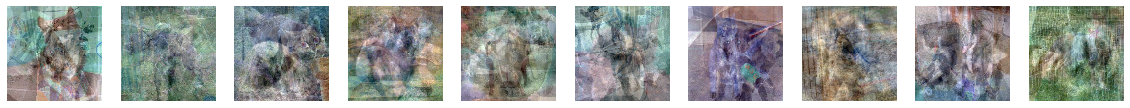

In [7]:
from sklearn.svm import LinearSVC

num_samples = 10
num_filters = 10

figure = plt.figure(figsize=(20.0, 20.0))
for i in range(num_filters):
    svm = LinearSVC()
    svm.fit(X_train[i * num_samples: i * num_samples + num_samples], y_train[i * num_samples: i * num_samples + num_samples])
    
    plt_idx = i
    plt.subplot(1, num_filters, i + 1)
    plt.axis('off')
    
    plot_filter(svm.coef_.copy())

More samples taken produce noice that results that SVM does not do well in this classification task.

In [8]:
svm = LinearSVC()
svm.fit(X_train[:1000], y_train[:1000])

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

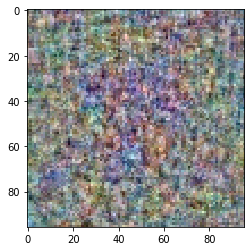

In [9]:
plot_filter(svm.coef_.copy())

We can see that more samples in a training dataset results in a more noice filter image which results in smaller accuracy. However, single SVM trained on small number of samples gives filter on which information that this filter is looking for is visible. Hence, maybe what can be done is to train a lot of SVM using few samples and involve some kind of Bagging method to make our predictions.

### Evaluating best Support Vector Machine classifier

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = svm.predict(X_test)
print('Confusion matrix\n', confusion_matrix(y_test, y_pred))
print('\nClassification report\n', classification_report(y_test, y_pred))

Confusion matrix
 [[1396 1104]
 [1144 1356]]

Classification report
               precision    recall  f1-score   support

         0.0       0.55      0.56      0.55      2500
         1.0       0.55      0.54      0.55      2500

    accuracy                           0.55      5000
   macro avg       0.55      0.55      0.55      5000
weighted avg       0.55      0.55      0.55      5000



### Support Vector Machine with non-linear kernel

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_params = [
    {'kernel': ['poly', 'rbf', 'sigmoid']}
]

grid_search = GridSearchCV(estimator=SVC(gamma='auto'),
                           param_grid=svm_params,
                           cv=3)

grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'kernel': ['poly', 'rbf', 'sigmoid']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
best_svm = grid_search.best_estimator_

print('Best SVM classifier obtain has following parameters')
best_svm

Best SVM classifier obtain has following parameters


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Evaluating best non-linear SVM classifier

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = best_svm.predict(X_test)
print('Confusion matrix\n', confusion_matrix(y_test, y_pred))
print('\nClassification report\n', classification_report(y_test, y_pred))

Confusion matrix
 [[1195 1305]
 [ 905 1595]]

Classification report
               precision    recall  f1-score   support

         0.0       0.57      0.48      0.52      2500
         1.0       0.55      0.64      0.59      2500

    accuracy                           0.56      5000
   macro avg       0.56      0.56      0.56      5000
weighted avg       0.56      0.56      0.56      5000

